In [2]:
using Pkg
Pkg.activate("F:/Tue/PhD/GP_playgroundcode")

  Activating project at `F:\Tue\PhD\GP_playgroundcode`


In [3]:
using ReactiveMP, KernelFunctions, Distributions, LinearAlgebra,GraphPPL, Rocket,Plots,Revise 
include("utils.jl")
pgfplotsx()
import StatsFuns: log2π

In [4]:
xmin, xmax = -3, 3  # Bounds of the data
N = 200# Number of samples
xtrain = sort(rand(Uniform(xmin, xmax), N))
xtest = collect(range(xmin - 0.1, xmax + 0.1; length=600));
xtest = sort(vcat(xtest,xtrain))
precision = 100
ytrain = sinc.(xtrain) + randn(N) * sqrt(1/precision);
f_true = sinc.(xtest);

In [5]:
kernelfunc(θ) = with_lengthscale(SqExponentialKernel(),θ)

kernelfunc (generic function with 1 method)

In [8]:
# test new thing
@model function gpprocess(n,kernelfunc,meanfunc,train,test)
    y = datavar(Float64,n)
    meta = ProcessMeta(nothing,nothing,nothing,nothing)

    x = randomprocess(test,train,meta)
    ####
    θ ~ NormalMeanVariance(0.1, 0.1)
    k ~ kernelfunc(θ)
    ####
    x ~ GaussianProcess(meanfunc,k) 
    γ ~ GammaShapeRate(1.0,0.1)
    for i=1:n 
        y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i,nothing,nothing,nothing)}
    end
end

In [1]:
# #make faster
# @model function gpprocess(n,kernelfunc,meanfunc,train,test)
#     y = datavar(Float64,n)
#     meta = ProcessMeta(nothing,kernelmatrix(kernelfunc,xtrain,xtrain),kernelmatrix(kernelfunc,xtest,xtest),kernelmatrix(kernelfunc,xtest,xtrain))
#     x = randomprocess(test,train,meta)
#     x ~ GaussianProcess(meanfunc,kernelfunc) 
#     ####
#     # θ ~ NormalMeanPrecision(m,σ)
#     # k ~ kernelfunc(θ)
#     # x ~ GaussianProcess(meanfunc,k) 
#     #####
#     γ ~ GammaShapeRate(1.0,0.1)
#     for i=1:n 
#         y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i,meta.Kxx,meta.Kff,meta.Kfx)}
#     end
# end

LoadError: LoadError: UndefVarError: @model not defined
in expression starting at f:\Tue\PhD\GP_playgroundcode\gp_regression.ipynb:2

In [4]:
# original code
# @model function gpprocess(n,kernelfunc,meanfunc,train,test)
#     y = datavar(Float64,n)
#     x = randomprocess(test,train)
#     x ~ GaussianProcess(meanfunc,kernelfunc) 
#     γ ~ GammaShapeRate(1.0,0.1)
#     for i=1:n 
#         y[i] ~ NormalMeanPrecision(x, γ) where {meta=ProcessMeta(i,nothing,nothing,nothing)}
#     end
# end

In [10]:
function Distributions.entropy(pm::PointMass{F}) where {F <: Function}
    return ReactiveMP.InfCountingReal(Float64,-1)
end

function Distributions.entropy(pm::PointMass{F}) where {F <: Kernel}
    return ReactiveMP.InfCountingReal(Float64,-1)
end

@average_energy GaussianProcess (q_out::GaussianProcess, q_meanfunc::Any, q_kernelfunc::Any) = begin
    q_out.finitemarginal
    return -entropy(q_out.finitemarginal)
end

@average_energy NormalMeanPrecision (q_out::Any, q_μ::GaussianProcess, q_τ::Any,meta::ProcessMeta) = begin
    m_right, cov_right = mean_cov(q_μ.finitemarginal)
    kernelf = q_μ.kernelfunction
    meanf   = q_μ.meanfunction
    test    = q_μ.testinput
    train   = q_μ.traininput
    μ_mean, μ_var = predMVN(q_μ,test,[train[meta.index]],m_right)
    μ_var = clamp(μ_var[1],1e-8,huge)
    μ_mean = μ_mean[1]
    out_mean, out_var = mean_var(q_out)
    return (log2π - mean(log, q_τ) + mean(q_τ) * (μ_var + out_var + abs2(μ_mean - out_mean))) / 2
end

function ReactiveMP.entropy(p::GaussianProcess)
    return ReactiveMP.entropy(p.finitemarginal)
end

@rule NormalMeanPrecision(:μ, Marginalisation) (q_out::PointMass, q_τ::GammaShapeRate, meta::ProcessMeta) = begin 
    return @call_rule NormalMeanPrecision(:μ, Marginalisation) (q_out=q_out,q_τ=q_τ,meta=nothing)
end
@rule GaussianProcess(:out, Marginalisation) (q_meanfunc::PointMass, q_kernelfunc::PointMass) = begin 
    return GaussianProcess(q_meanfunc.point,q_kernelfunc.point,nothing,nothing,nothing,nothing)
end

In [11]:
#kernel_func =  Matern52Kernel() 
meanfunc   = (x) -> 0.0;

In [12]:
# This is the product function that computes the product of messages for GP node.
function ReactiveMP.messages_prod_fn(process::RandomProcess)
   return ReactiveMP.marginal_prod_fn(process)
end

function ReactiveMP.marginal_prod_fn(process::RandomProcess)
    test  = process.test_input
    train = process.train_input
    ####
    meta = process.meta
    ####
    return messages -> begin 
        message_vector = map(ReactiveMP.as_message, messages)
        process_message = getdata(message_vector[1])
        meanf = process_message.meanfunction
        kernelf = process_message.kernelfunction
        likelihood_messages = message_vector[2:end]
        m_right,cov_right = make_multivariate_message(likelihood_messages)
        
        #m, K = predMVN(meta,process_message,train, test, m_right,cov_right)
        invKff = cholinv(meta.Kff + K)
        m, K= predMVN(kernelf,meanf,train,test,m_right,cov_right) #Ismail code
        invKff = cholinv(meta.Kff + K)
        return Marginal(GaussianProcess(meanf,kernelf,MvNormalMeanCovariance(m,K),test,train, invKff),false,false)
    end
end

In [14]:
@constraints function gpconstraints()   
    q(x,γ) = q(x)q(γ)
end
nits = 10

iresult = inference(
    model = Model(gpprocess, length(ytrain), kernelfunc, meanfunc, xtrain,xtest),
    initmarginals = (γ = vague(GammaShapeRate),),
    options = model_options(limit_stack_depth = 500),
    constraints = gpconstraints(),
    iterations = nits,  
    data  = (y = ytrain,),
    showprogress=true,
    free_energy = true
)

ErrorException: `kernelfunc` is not available as a node in the inference engine. Used in `k ~ kernelfunc(...)` expression.
Use `@node` macro to add a custom factor node corresponding to `kernelfunc`. See `@node` macro for additional documentation and examples.


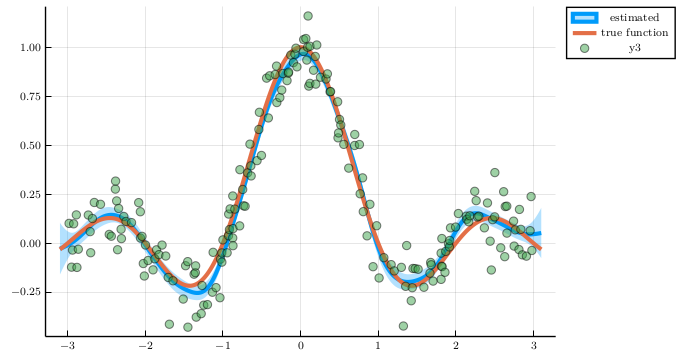

In [57]:
plot(xtest,mean(iresult.posteriors[:x][end].finitemarginal),ribbon=sqrt.(diag(cov(iresult.posteriors[:x][end].finitemarginal))),linewidth=3.0,label="estimated",fillalpha=0.3)
plot!(xtest,f_true,linewidth=3.0,label="true function")
scatter!(xtrain,ytrain, alpha=0.5)

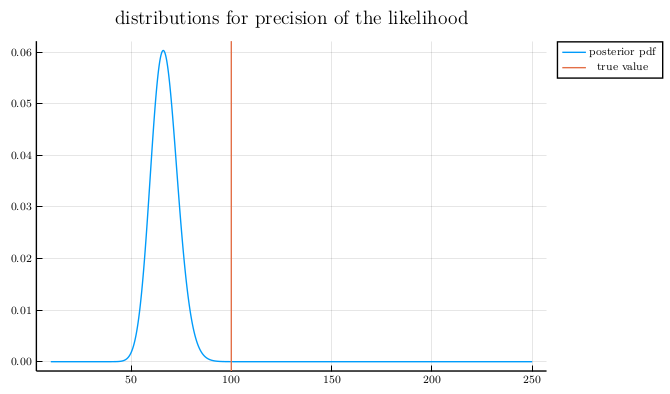

In [24]:
from  = 10
to    = 250
t     = collect(from:0.1:to)

plot(t,pdf.(iresult.posteriors[:γ][end],t),fillalpha=0.2,title="distributions for precision of the likelihood",label=" posterior pdf")
#     plot!(t, pdf.(GammaShapeRate(0.001,0.001),t),fillalpha=0.2,label="prior pdf")
vline!([precision],label="true value")
# gif(anim, "anim_fps15.gif", fps = 15)


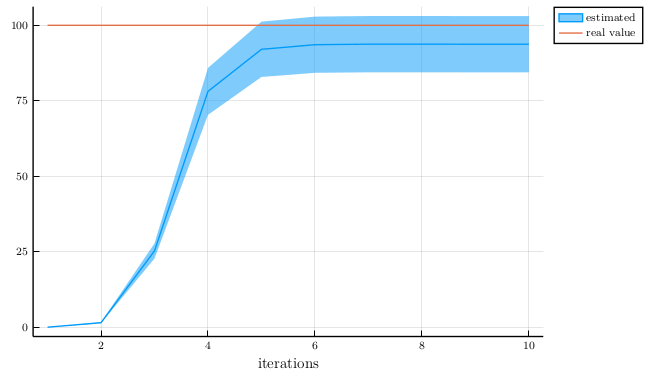

In [14]:
from = 1
to   = nits
plot(collect(from:to),mean.(iresult.posteriors[:γ])[from:to],ribbon=std.(iresult.posteriors[:γ])[from:to],label="estimated")
plot!(collect(from:to),precision*ones(to-from+1),label="real value")
xlabel!("iterations")



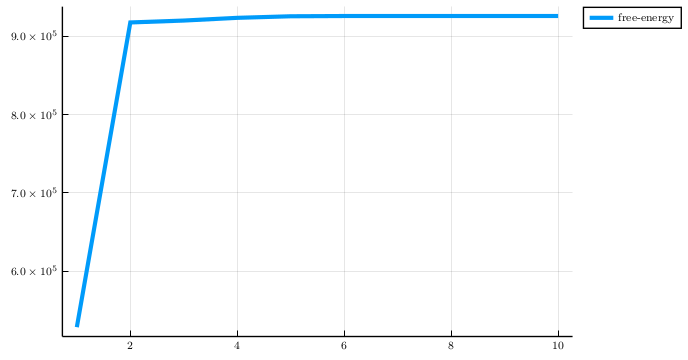

In [15]:
plot(iresult.free_energy,linewidth=3.0,label="free-energy")